In [18]:
import re
from datetime import datetime

In [19]:
import os
import geopandas as gpd
import geemap
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import LineString

# constante requerida
namespace = {"kml": "http://www.opengis.net/kml/2.2"}

In [20]:
# Directorio donde están los archivos KML
path_kml = r'C:/LOGS/10/KML/'
contenido = os.listdir(path_kml)
len(contenido)

24

In [21]:
contenido

['Nov-1st-2023-01-52AM-Flight-Airdata.kml',
 'Nov-1st-2023-03-02AM-Flight-Airdata.kml',
 'Nov-1st-2023-04-33AM-Flight-Airdata.kml',
 'Nov-1st-2023-11-28PM-Flight-Airdata.kml',
 'Nov-1st-2023-12-10AM-Flight-Airdata.kml',
 'Nov-4th-2023-04-45PM-Flight-Airdata.kml',
 'Nov-4th-2023-07-49PM-Flight-Airdata.kml',
 'Nov-4th-2023-08-16PM-Flight-Airdata.kml',
 'Nov-4th-2023-11-39PM-Flight-Airdata.kml',
 'Nov-4th-2023-11-56PM-Flight-Airdata.kml',
 'Nov-5th-2023-04-27AM-Flight-Airdata.kml',
 'Nov-5th-2023-04-59AM-Flight-Airdata.kml',
 'Nov-5th-2023-09-34PM-Flight-Airdata.kml',
 'Nov-5th-2023-10-10PM-Flight-Airdata.kml',
 'Nov-5th-2023-10-40PM-Flight-Airdata.kml',
 'Nov-5th-2023-11-41PM-Flight-Airdata.kml',
 'Nov-6th-2023-01-46AM-Flight-Airdata.kml',
 'Nov-6th-2023-02-15AM-Flight-Airdata.kml',
 'Nov-6th-2023-05-09AM-Flight-Airdata.kml',
 'Nov-6th-2023-12-02AM-Flight-Airdata.kml',
 'Oct-31st-2023-07-48AM-Flight-Airdata.kml',
 'Oct-31st-2023-08-55PM-Flight-Airdata.kml',
 'Oct-31st-2023-09-17PM-Flight

In [22]:
def extraer_fecha(fecha_txt):
    match = re.search(r"([A-Za-z]{3}-\d{1,2}[a-z]{2}-\d{4})", fecha_txt)
    return match.group(1) if match else None

def format_date(date_str):
    try:
        # Eliminar sufijos ordinales para facilitar la conversión
        date_without_suffix = re.sub(r'(st|nd|rd|th)', '', date_str)
        return pd.to_datetime(date_without_suffix, format='%b-%d-%Y').strftime('%d/%m/%Y')
    except:
        return None

def week_number(date_str):
    """
    Retorna el número de semana del año para una fecha dada en formato "dd/mm/aaaa".
    """
    try:
        date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
        return date_obj.isocalendar()[1]  # El segundo valor de isocalendar() es el número de semana
    except:
        return None

In [23]:
# lista para almacenar nombres de archivo
file_name = []
# lista para alamcenar recorridos
lineas = []

# itera sobre la lista de nombres de archivos
for i in contenido:
    # directorio + nombre de archivo
    path = path_kml + i
    # leer el arbol de contenido del archivo
    tree = ET.parse(path)
    root = tree.getroot()
    for placemark in root.findall(".//kml:Placemark", namespace):
        coord_text = placemark.find(".//kml:coordinates", namespace).text.strip()
        # obtiene las cooredenadas
        coords = coord_text.split('\n')
        # lista para guardar las coors
        coordinates = []
        # recorre las coors
        for j in coords:
            # split para separa el 3er elemento que acompaña las coors
            coord = j.split(',')
            # agrega las coors a la lista
            coordinates.append((float(coord[0]), float(coord[1])))
    # conviente en DF
    df = pd.DataFrame(coordinates, columns=['Longitude', 'Latitude'])
    # convierte en GDF
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    # convierte el GDF en Linea
    line = LineString(gdf.geometry.tolist())
    # se almacena en listas el nombre del archivo y la geomedia del recorrido
    file_name.append(i)
    lineas.append(line)

In [24]:
fechas = [extraer_fecha(i) for i in file_name]

In [25]:
fechas = [format_date(i) for i in fechas]

In [26]:
semanas = [week_number(i) for i in fechas]

In [27]:
# dic con la geometria y el file_name
data_lineas = {
    'geometry': lineas,
    'nombre': file_name,
    'fecha' : fechas,
    'semana' : semanas
}

In [28]:
gdf_lineas = gpd.GeoDataFrame(data_lineas)

In [29]:
gdf_lineas.crs = "EPSG:4326"

In [30]:
gdf_lineas = gdf_lineas.to_crs(epsg=32720)

In [31]:
gdf_lineas

,geometry,nombre,fecha,semana
0,"LINESTRING (470124.129 8100366.716, 470124.235...",Nov-1st-2023-01-52AM-Flight-Airdata.kml,01/11/2023,44
1,"LINESTRING (469958.702 8098420.080, 469958.712...",Nov-1st-2023-03-02AM-Flight-Airdata.kml,01/11/2023,44
2,"LINESTRING (485378.699 8087741.410, 485378.720...",Nov-1st-2023-04-33AM-Flight-Airdata.kml,01/11/2023,44
3,"LINESTRING (485030.211 8087014.870, 485030.190...",Nov-1st-2023-11-28PM-Flight-Airdata.kml,01/11/2023,44
4,"LINESTRING (470019.413 8099606.924, 470019.402...",Nov-1st-2023-12-10AM-Flight-Airdata.kml,01/11/2023,44
5,"LINESTRING (481179.144 8078869.314, 481179.154...",Nov-4th-2023-04-45PM-Flight-Airdata.kml,04/11/2023,44
6,"LINESTRING (467982.840 8077278.758, 467982.883...",Nov-4th-2023-07-49PM-Flight-Airdata.kml,04/11/2023,44
7,"LINESTRING (467982.530 8077279.886, 467982.499...",Nov-4th-2023-08-16PM-Flight-Airdata.kml,04/11/2023,44
8,"LINESTRING (485358.474 8085884.206, 485358.506...",Nov-4th-2023-11-39PM-Flight-Airdata.kml,04/11/2023,44
9,"LINESTRING (485358.442 8085884.538, 485358.602...",Nov-4th-2023-11-56PM-Flight-Airdata.kml,04/11/2023,44


<AxesSubplot:>

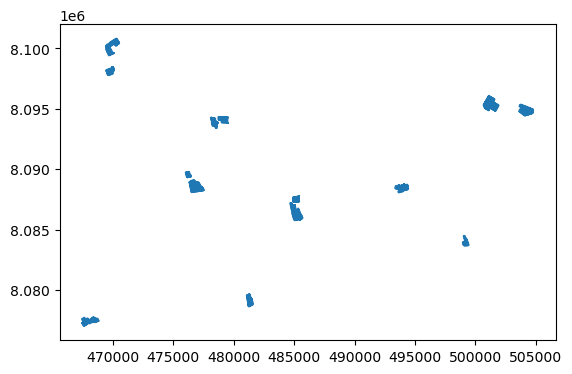

In [32]:
gdf_lineas.plot()

In [33]:
len(gdf_lineas)

24

In [34]:
gdf_lineas.to_file('capa_logs', driver="ESRI Shapefile")